In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox


2021-11-08 23:59:44.198486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-08 23:59:44.198527: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Conv LSTM Layer
<center><img src="assets/convlstm.png"></img></center>

In our case, sequencial images, one approach is using ConvLSTM layers. It is a Recurrent layer, just like the LSTM, but internal matrix multiplications are exchanged with convolution operations. As a result, the data that flows through the ConvLSTM cells keeps the input dimension (3D in our case) instead of being just a 1D vector with features.<br>

A different approach of a ConvLSTM is a Convolutional-LSTM model, in which the image passes through the convolutions layers and its result is a set flattened to a 1D array with the obtained features. When repeating this process to all images in the time set, the result is a set of features over time, and this is the LSTM layer input.<br>

From now on, the data format will be defined as "channels_first". This results on images having the format (channels, rows, cols). A colourful 300x300 pixels picture has 3 channels, one for each primary colour (Red, Green, Blue) and the format (3, 300, 300). If it was "channels_last", the keras default for convolutional layers, the format would be (rows, cols, channels).<br>

## Input Shape
The LSTM cell input is a set of data over time, that is, a 3D tensor with shape (samples, time_steps, features). The Convolution layer input is a set of images as a 4D tensor with shape (samples, channels, rows, cols).<br>
The input of a ConvLSTM is a set of images over time as a 5D tensor with shape (samples, time_steps, channels, rows, cols)

## Output Shape
The LSTM cell output depends on the return_sequences atribute. When set True, the output is a sequence over time (one output for each input). In this case, the output is a 3D tensor with shape (samples, time_steps, features). When return_sequences is set False (the default), the output is the last value of the sequence, that is, a 2D tensor with shape (samples, features).<br>
The Convolution layer output is a set of images as a 4D tensor with shape (samples, filters, rows, cols).<br>
The LSTM cell output depends on the return_sequences atribute. When set True, the output is a sequence over time (one output for each input). In this case, the output is a 3D tensor with shape (samples, time_steps, features). When return_sequences is set False (the default), the output is the last value of the sequence, that is, a 2D tensor with shape (samples, features).<br>
The Convolution layer output is a set of images as a 4D tensor with shape (samples, filters, rows, cols).

In [2]:
tf.keras.layers.ConvLSTM1D(
    filters=1, kernel_size=1, strides=1, padding='valid', data_format=None,
    dilation_rate=1, activation='tanh',
    recurrent_activation='hard_sigmoid', use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', unit_forget_bias=True,
    kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None,
    activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None,
    bias_constraint=None, return_sequences=False, return_state=False,
    go_backwards=False, stateful=False, dropout=0.0, recurrent_dropout=0.0
)

## Arguments
- **filters** 	Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
- **kernel_size** 	An integer or tuple/list of n integers, specifying the dimensions of the convolution window.
- **strides** 	An integer or tuple/list of n integers, specifying the strides of the convolution. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
- **padding** 	One of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
- **data_format** 	A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch, time, ..., channels) while channels_first corresponds to inputs with shape (batch, time, channels, ...). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "channels_last".
- **dilation_rate** 	An integer or tuple/list of n integers, specifying the dilation rate to use for dilated convolution. Currently, specifying any dilation_rate value != 1 is incompatible with specifying any strides value != 1.
- **activation** 	Activation function to use. By default hyperbolic tangent activation function is applied (tanh(x)).
- **recurrent_activation** 	Activation function to use for the recurrent step.
- **use_bias** 	Boolean, whether the layer uses a bias vector.
- **kernel_initializer** 	Initializer for the kernel weights matrix, used for the linear transformation of the inputs.
- **recurrent_initializer** 	Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state.
- **bias_initializer** 	Initializer for the bias vector.
- **unit_forget_bias** 	Boolean. If True, add 1 to the bias of the forget gate at initialization. Use in combination with bias_initializer="zeros". This is recommended in Jozefowicz et al., 2015
- **kernel_regularizer** 	Regularizer function applied to the kernel weights matrix.
- **recurrent_regularizer** 	Regularizer function applied to the recurrent_kernel weights matrix.
- **bias_regularizer** 	Regularizer function applied to the bias vector.
- **activity_regularizer** 	Regularizer function applied to.
- **kernel_constraint** 	Constraint function applied to the kernel weights matrix.
- **recurrent_constraint** 	Constraint function applied to the recurrent_kernel weights matrix.
- **bias_constraint** 	Constraint function applied to the bias vector.
- **return_sequences** 	Boolean. Whether to return the last output in the output sequence, or the full sequence. (default False)
- **return_state** 	Boolean Whether to return the last state in addition to the output. (default False)
- **go_backwards** 	Boolean (default False). If True, process the input sequence backwards.
- **stateful** 	Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
- **dropout** 	Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
- **recurrent_dropout** 	Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state. filters	Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
- **kernel_size** 	An integer or tuple/list of n integers, specifying the dimensions of the convolution window.
- **strides** 	An integer or tuple/list of n integers, specifying the strides of the convolution. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
- **padding** 	One of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
- **data_format** 	A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch, time, ..., channels) while channels_first corresponds to inputs with shape (batch, time, channels, ...). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "channels_last".
- **dilation_rate** 	An integer or tuple/list of n integers, specifying the dilation rate to use for dilated convolution. Currently, specifying any dilation_rate value != 1 is incompatible with specifying any strides value != 1.
- **activation** 	Activation function to use. By default hyperbolic tangent activation function is applied (tanh(x)).
- **recurrent_activation** 	Activation function to use for the recurrent step.
- **use_bias** 	Boolean, whether the layer uses a bias vector.
- **kernel_initializer** 	Initializer for the kernel weights matrix, used for the linear transformation of the inputs.
- **recurrent_initializer** 	Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state.
- **bias_initializer** 	Initializer for the bias vector.
- **unit_forget_bias** 	Boolean. If True, add 1 to the bias of the forget gate at initialization. Use in combination with bias_initializer="zeros". This is recommended in Jozefowicz et al., 2015
- **kernel_regularizer** 	Regularizer function applied to the kernel weights matrix.
- **recurrent_regularizer** 	Regularizer function applied to the recurrent_kernel weights matrix.
- **bias_regularizer** 	Regularizer function applied to the bias vector.
- **activity_regularizer** 	Regularizer function applied to.
- **kernel_constraint** 	Constraint function applied to the kernel weights matrix.
- **recurrent_constraint** 	Constraint function applied to the recurrent_kernel weights matrix.
- **bias_constraint** 	Constraint function applied to the bias vector.
- **return_sequences** 	Boolean. Whether to return the last output in the output sequence, or the full sequence. (default False)
- **return_state** 	Boolean Whether to return the last state in addition to the output. (default False)
- **go_backwards** 	Boolean (default False). If True, process the input sequence backwards.
- **stateful** 	Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
- **dropout** 	Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
- **recurrent_dropout** 	Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state. 

## Example

```python
cnn = Sequential()
cnn.add(Conv2D(...))
cnn.add(MaxPooling2D(...))
cnn.add(Flatten())
# define LSTM model
model = Sequential()
model.add(TimeDistributed(cnn, ...))
model.add(LSTM(..))
model.add(Dense(...))
```

```python
model = Sequential()
# define CNN model
model.add(TimeDistributed(Conv2D(...))
model.add(TimeDistributed(MaxPooling2D(...)))
model.add(TimeDistributed(Flatten()))
# define LSTM model
model.add(LSTM(...))
model.add(Dense(...))
```

## Example. Next Frame Prediction
The Convolutional LSTM architectures bring together time series processing and computer vision by introducing a convolutional recurrent cell in a LSTM layer. In this example, we will explore the Convolutional LSTM model in an application to next-frame prediction, the process of predicting what video frames come next given a series of past frames.

### Dataset Construction
For next-frame prediction, our model will be using a previous frame, which we'll call f_n, to predict a new frame, called f_(n + 1). To allow the model to create these predictions, we'll need to process the data such that we have "shifted" inputs and outputs, where the input data is frame x_n, being used to predict frame y_(n + 1).

In [3]:
# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))


819216384/819200096 [==============================] - 99s 0us/step
Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


### Data Visualization
Our data consists of sequences of frames, each of which are used to predict the upcoming frame. Let's take a look at some of these sequential frames.

Displaying frames for example 235.


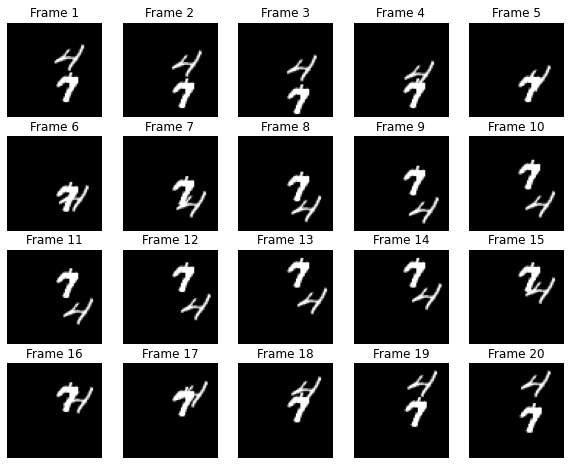

In [4]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

### Model Construction
To build a Convolutional LSTM model, we will use the ConvLSTM2D layer, which will accept inputs of shape (batch_size, num_frames, width, height, channels), and return a prediction movie of the same shape.

In [5]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


2021-11-08 23:48:11.082485: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-08 23:48:11.083009: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-08 23:48:11.083847: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aspire): /proc/driver/nvidia/version does not exist
2021-11-08 23:48:11.087091: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Tain Model

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

### Frame Prediction Visualizations
With our model now constructed and trained, we can generate some example frame predictions based on a new video.<br>

We'll pick a random example from the validation set and then choose the first ten frames from them. From there, we can allow the model to predict 10 new frames, which we can compare to the ground truth frame predictions.<br>

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

### Predict Videos

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)
